# Demonstration of anomaly detection with CVAE using DASHlink data

**Author: Milad Memarzadeh (milad.memarzadeh@nasa.gov)**


# Import Libraries

In [70]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, precision_recall_curve, average_precision_score
from sklearn.utils import shuffle

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# Load and preprocess data

In [71]:
# Define the path to the dataset
data_dir = 'C:/Users/jed95/Documents/GitHub/anomaly_detection/dataset/yahoo_s5/A2Benchmark'  # Adjust the path as necessary

# Get the list of all CSV files in the directory
file_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]

# Load all files into a single DataFrame
df_list = []
for file in file_list:
    df = pd.read_csv(file)
    df_list.append(df)

data = pd.concat(df_list, ignore_index=True)
print("Data shape:", data.shape)


Data shape: (142100, 3)


In [72]:
# Check for missing values
print("Missing values:", data.isnull().sum())

# For simplicity, drop missing values (if any)
data.dropna(inplace=True)


Missing values: timestamp     0
value         0
is_anomaly    0
dtype: int64


In [73]:
values = data["value"].values.reshape(-1, 1)
scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values)

# Create Sequences

In [74]:
window_size = 30

def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size):
        window = data[i : i + window_size]
        windows.append(window)
    return np.array(windows)


windows = create_windows(values_scaled, window_size)
print("Sequences shape:", windows.shape)




Sequences shape: (142070, 30, 1)


# Split data into labeled and unlabeled sets

In [59]:
train_ratio = 0.51
train_size = int(len(windows) * train_ratio)
train_data = windows[:train_size]
test_data = windows[train_size:]
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (72465, 10, 1)
Test data shape: (69625, 10, 1)


In [60]:
# TODO Shuffle data

#X_train, y_train = shuffle(X_train, y_train, random_state=42)
#X_test, y_test = shuffle(X_test, y_test, random_state=42)


# Convert Data to Tensors

# Create Data Loaders for Labeled and Unlabeled Data

In [61]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx].transpose(1, 0)

In [62]:
train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Instantiate and Train the Conditional VAE

In [63]:
from source.utilsVAEs5 import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 10
num_param = 1
scale_flag = 0
model = VAE(latent_dim, num_param, window_size, scale_flag).to(device)

In [64]:
# 3. Define the training function
def likelihood_loss(x_recon, x, metric="MSE"):
    if metric == "MSE":
        loss = nn.MSELoss(reduction="none")
    elif metric == "BCE":
        loss = nn.BCELoss(reduction="none")
    else:
        raise ValueError("Invalid metric. Use 'MSE' or 'BCE'.")
    return loss(x_recon, x).mean(dim=[1, 2])


def train_model(model, optimizer, train_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        rec_loss_total = 0
        kl_loss_total = 0

        for X_batch in train_loader:
            X_batch = X_batch.to(device)

            optimizer.zero_grad()
            x_rec = model(X_batch)

            likelihood = likelihood_loss(x_rec, X_batch, metric="MSE")
            rec_loss = torch.mean(likelihood)
            kl_div = torch.mean(model.kl_div)
            loss = rec_loss + kl_div * 0.1

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            rec_loss_total += rec_loss.item()
            kl_loss_total += kl_div.item()

        print(
            f"Epoch [{epoch+1}/{num_epochs}], "
            f"Total Loss: {total_loss:.4f}, "
            f"Rec Loss: {rec_loss_total:.4f}, "
            f"KL Div: {kl_loss_total:.4f}"
        )
    return model

In [65]:
# 4. Train the model
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10
model = train_model(model, optimizer, train_loader, num_epochs=num_epochs)

Epoch [1/10], Total Loss: 3.5240, Rec Loss: 3.5131, KL Div: 0.1090
Epoch [2/10], Total Loss: 1.8502, Rec Loss: 1.8501, KL Div: 0.0017
Epoch [3/10], Total Loss: 1.8428, Rec Loss: 1.8426, KL Div: 0.0014
Epoch [4/10], Total Loss: 1.8380, Rec Loss: 1.8379, KL Div: 0.0009
Epoch [5/10], Total Loss: 1.8270, Rec Loss: 1.8269, KL Div: 0.0004
Epoch [6/10], Total Loss: 1.8226, Rec Loss: 1.8225, KL Div: 0.0008
Epoch [7/10], Total Loss: 1.8165, Rec Loss: 1.8164, KL Div: 0.0009
Epoch [8/10], Total Loss: 1.8159, Rec Loss: 1.8159, KL Div: 0.0008
Epoch [9/10], Total Loss: 1.8139, Rec Loss: 1.8138, KL Div: 0.0006
Epoch [10/10], Total Loss: 1.8095, Rec Loss: 1.8095, KL Div: 0.0005


In [66]:
model.eval()
reconstruction_errors = []
all_true_labels = []

with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        x_rec = model(X_batch)
        error = likelihood_loss(x_rec, X_batch, metric="MSE").cpu().numpy()
        reconstruction_errors.append(error)

        if "is_anomaly" in data.columns:
            idx = len(reconstruction_errors) - 1
            true_label = data["is_anomaly"].values[train_size + idx + window_size]
            all_true_labels.append(true_label)

reconstruction_errors = np.concatenate(reconstruction_errors)

# Set anomaly threshold
k = 2
threshold = reconstruction_errors.mean() + k * reconstruction_errors.std()
print(f"Anomaly Threshold: {threshold:.4f}")

Anomaly Threshold: 0.0548


# Evaluate the Model and Detect Anomalies

Precision: 0.0056
Recall:    0.0756
F1 Score:  0.0104
Confusion Matrix:
[[66369  3031]
 [  208    17]]
Precision = 0.56%, recall = 7.56% and F1-score = 1.04%


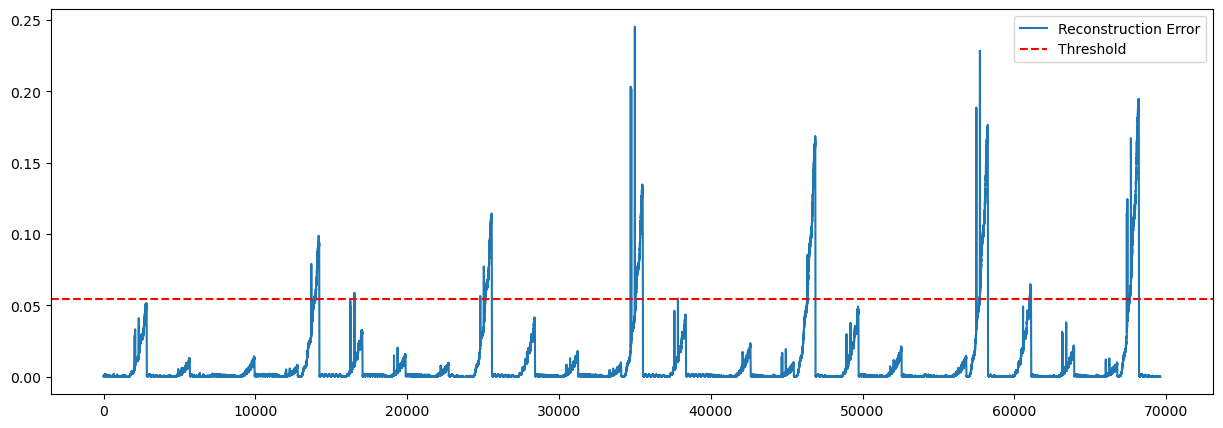

In [67]:
anomalies = reconstruction_errors > threshold

# Evaluate performance
if "is_anomaly" in data.columns:
    from sklearn.metrics import (
        precision_score,
        recall_score,
        f1_score,
        confusion_matrix,
    )

    true_labels = np.array(all_true_labels)
    pred_labels = anomalies.astype(int)

    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    cm = confusion_matrix(true_labels, pred_labels)

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
info = precision_recall_fscore_support(true_labels, pred_labels)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))
# Visualize results
plt.figure(figsize=(15, 5))
plt.plot(reconstruction_errors, label="Reconstruction Error")
plt.axhline(y=threshold, color="r", linestyle="--", label="Threshold")
plt.legend()
plt.show()




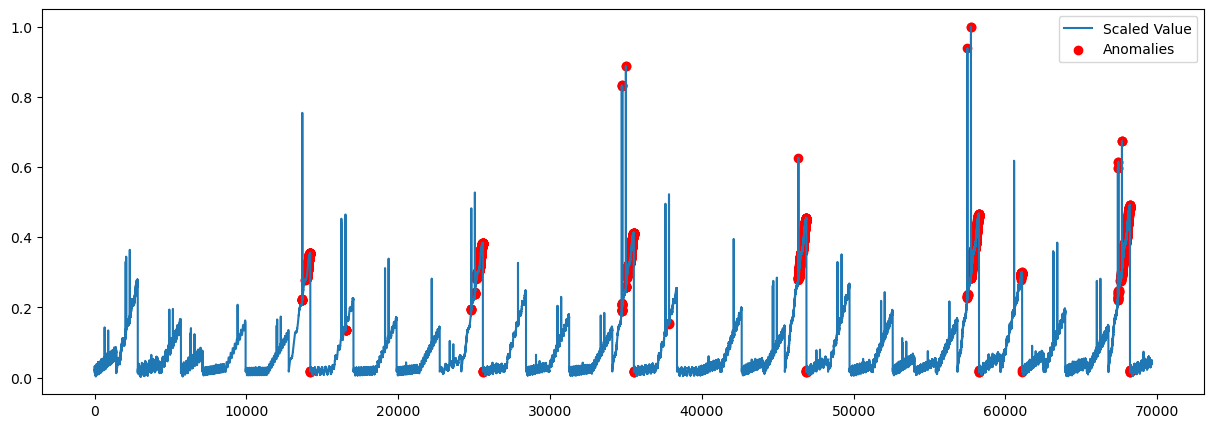

In [68]:
test_values = values_scaled[train_size + window_size :]

plt.figure(figsize=(15, 5))
plt.plot(test_values, label="Scaled Value")
anomaly_indices = np.where(anomalies)[0]
plt.scatter(anomaly_indices, test_values[anomaly_indices], color="r", label="Anomalies")
plt.legend()
plt.show()

In [69]:
def compute_anomaly_scores(model, data_loader):
    model.eval()
    anomaly_scores = []
    true_labels = []
    predictions = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.unsqueeze(1).to(device)
            y_batch = y_batch.to(device)

            x_rec, class_logits = model(X_batch)
            y_probs = F.softmax(class_logits, dim=1)

            # Reconstruction error
            rec_error = torch.mean((X_batch - x_rec) ** 2, dim=[1, 2])

            # Classification probability for anomaly class
            anomaly_prob = y_probs[:, 1]

            # Combine scores
            anomaly_score = rec_error * anomaly_prob

            anomaly_scores.extend(anomaly_score.cpu().numpy())
            true_labels.extend(y_batch.cpu().numpy())
            predictions.extend(torch.argmax(class_logits, dim=1).cpu().numpy())

    return np.array(anomaly_scores), np.array(true_labels), np.array(predictions)

# Compute anomaly scores
train_anomaly_scores, train_true_labels, train_predictions = compute_anomaly_scores(model, train_loader)


test_anomaly_scores, test_true_labels, test_predictions = compute_anomaly_scores(model, test_loader)
#print(test_anomaly_scores)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))



ValueError: too many values to unpack (expected 2)

In [ ]:
# Define the scale factor
scale = 2  # You can adjust this value
# Calculate the threshold
threshold = np.mean(train_anomaly_scores) + scale * np.std(train_anomaly_scores)
print(f"Anomaly Detection Threshold: {threshold}")
# Classify test data based on threshold
threshold_predictions = (test_anomaly_scores > threshold).astype(int)

# Evaluate threshold-based predictions
print("Threshold-based Classification Report:")
print(classification_report(test_true_labels, threshold_predictions, target_names=['Normal', 'Anomaly']))

# Confusion matrix
cm_threshold = confusion_matrix(test_true_labels, threshold_predictions)
print("Threshold-based Confusion Matrix:")
print(cm_threshold)

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(train_anomaly_scores[train_true_labels == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(train_anomaly_scores[train_true_labels == 1], bins=50, alpha=0.6, label='Anomaly')
plt.title('Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
def plot_anomaly_scores_scatter(anomaly_scores, true_labels, threshold):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=true_labels, cmap='coolwarm', label='Data Point')
    plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
    plt.title('Anomaly Scores Scatter Plot')
    plt.xlabel('Sample Index')
    plt.ylabel('Anomaly Score')
    plt.legend()
    plt.show()

# Call the function
plot_anomaly_scores_scatter(test_anomaly_scores, test_true_labels, threshold)


In [ ]:


# Set plot style
sns.set(style='whitegrid')
def plot_anomaly_score_histogram(anomaly_scores, true_labels, threshold):
    plt.figure(figsize=(10, 6))
    sns.histplot(anomaly_scores[true_labels == 0], bins=50, color='green', label='Normal', kde=True, stat='density')
    sns.histplot(anomaly_scores[true_labels == 1], bins=50, color='red', label='Anomaly', kde=True, stat='density')
    plt.axvline(threshold, color='blue', linestyle='--', label='Threshold')
    plt.title('Histogram of Anomaly Scores')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Call the function
plot_anomaly_score_histogram(test_anomaly_scores, test_true_labels, threshold)


In [ ]:


# Compute AUC-ROC
auc_score = roc_auc_score(test_true_labels, test_anomaly_scores)
print(f"AUC-ROC Score: {auc_score:.4f}")

# Compute Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(test_true_labels, test_anomaly_scores)
ap_score = average_precision_score(test_true_labels, test_anomaly_scores)
print(f"Average Precision Score: {ap_score:.4f}")


In [ ]:
fpr, tpr, thresholds = roc_curve(test_true_labels, test_anomaly_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:


# Classification report
print("Classification Report:")
print(classification_report(test_true_labels, test_predictions, target_names=['Normal', 'Anomaly']))

# Confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

# Compute AUC-ROC
auc_score = roc_auc_score(test_true_labels, test_anomaly_scores)
print(f"AUC-ROC Score: {auc_score:.4f}")


In [ ]:


plt.figure(figsize=(10, 6))
plt.hist(test_anomaly_scores[test_true_labels == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(test_anomaly_scores[test_true_labels == 1], bins=50, alpha=0.6, label='Anomaly')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Anomaly Score Distribution with Threshold')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()
